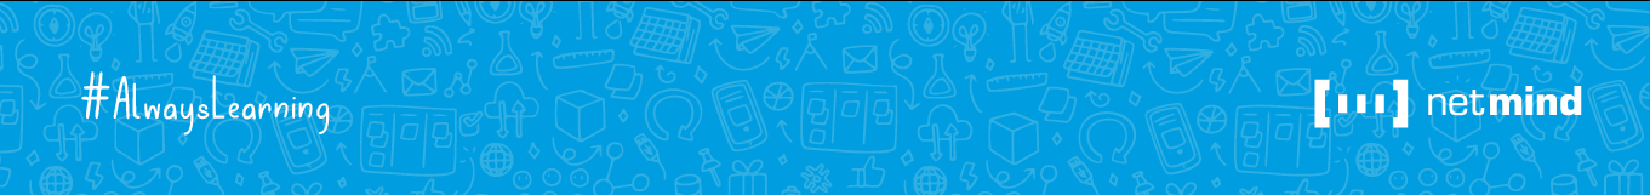
# **Despliegue de un modelo en un endpoint por lotes (batch)**

En muchos escenarios de producción, las tareas de ejecución prolongada que tratan con grandes cantidades de datos se realizan como operaciones por lotes. 

En el aprendizaje automático, la inferencia por lotes se usa para aplicar un modelo predictivo a varios casos de forma asincrónica y escribir los resultados en un archivo o base de datos.

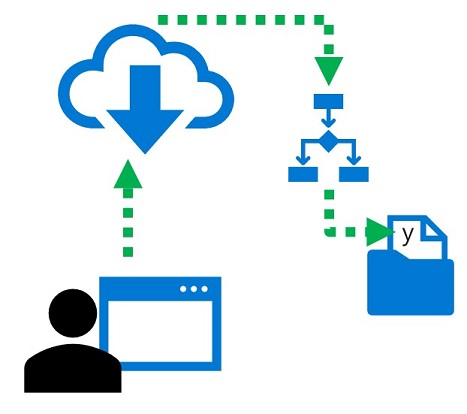

## **Creación de un endpoint por lotes**

Para crear un endpoint por lotes, se usa la clase [`BatchEndpoint`](https://learn.microsoft.com/en-us/python/api/azure-ai-ml/azure.ai.ml.entities.batchendpoint?view=azure-python). 

Los nombres de endpoint deben ser únicos dentro de una región de Azure.

In [ ]:
# create a batch endpoint
endpoint = BatchEndpoint(
    name="endpoint-example",
    description="A batch endpoint",
)

ml_client.batch_endpoints.begin_create_or_update(endpoint)

## **Despliegue de un modelo en un endpoint por lotes**

Se pueden desplegar varios modelos en un endpoint por lotes. 

Siempre que se llame al endpoint, se usará el deploy predeterminado, a menos que se especifique lo contrario.

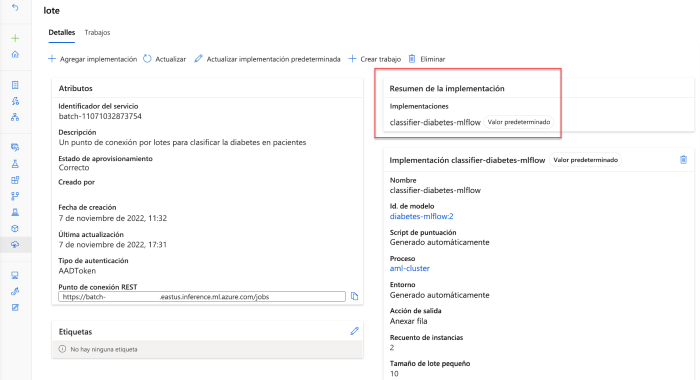

### Uso de clústeres

- El tipo de proceso ideal a usar es el clúster de proceso de Azure Machine Learning. 
- Si se desea que el trabajo de puntuación por lotes procese los nuevos datos en lotes paralelos, se debe aprovisionar un clúster de proceso con más de una instancia máxima.

Para crear un clúster:

In [ ]:
from azure.ai.ml.entities import AmlCompute

cpu_cluster = AmlCompute(
    name="aml-cluster",
    type="amlcompute",
    size="STANDARD_DS11_V2",
    min_instances=0,
    max_instances=4,
    idle_time_before_scale_down=120,
    tier="Dedicated",
)

cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

## **deploy de un modelo MLflow**

### Registro de un modelo MLflow
Para evitar la necesidad de un entorno y un script de puntuación, es necesario registrar un modelo MLflow en el área de trabajo de Azure Machine Learning y poder desplegarlo en un endpoint por lotes.

Para registrar un modelo de MLflow, se usa la clase `Model` y se especifica que el tipo de modelo `MLFLOW_MODEL`. 

> Más información: https://learn.microsoft.com/es-es/azure/machine-learning/concept-mlflow-models#the-mlmodel-format?azure-portal=true

In [ ]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

model_name = 'mlflow-model'
model = ml_client.models.create_or_update(
    Model(name=model_name, path='./model', type=AssetTypes.MLFLOW_MODEL)
)

### Deploy del modelo

Para desplegar un modelo de MLflow en un punto de conexión por lotes, se usa la clase BatchDeployment.
- Al desplegar un modelo, se deberá especificar cómo se desea que se comporte el job de puntuación por lotes. 
- La ventaja de usar un clúster es que puede ejecutar el script de puntuación en instancias independientes en paralelo.

Al configurar el despliegue, puede especificar:
- `instance_count`: recuento de nodos de proceso que se van a usar para generar predicciones.
- `max_concurrency_per_instance`: número máximo de ejecuciones de script de puntuación en paralelo por nodo de proceso.
- `mini_batch_size`: número de archivos pasados en cada ejecución del script de puntuación.
- `output_action`: qué hacer con las predicciones (summary_only o append_row).
- `output_file_name`: archivo al que se anexarán las predicciones, si elige append_row para output_action.

> Más información: https://learn.microsoft.com/es-es/python/api/azure-ai-ml/azure.ai.ml.entities.batchdeployment

In [ ]:
from azure.ai.ml.entities import BatchDeployment, BatchRetrySettings
from azure.ai.ml.constants import BatchDeploymentOutputAction

deployment = BatchDeployment(
    name="forecast-mlflow",
    description="A sales forecaster",
    endpoint_name=endpoint.name,
    model=model,
    compute="aml-cluster",
    instance_count=2,
    max_concurrency_per_instance=2,
    mini_batch_size=2,
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name="predictions.csv",
    retry_settings=BatchRetrySettings(max_retries=3, timeout=300),
    logging_level="info",
)
ml_client.batch_deployments.begin_create_or_update(deployment)

## **Deploy de un modelo personalizado**

### Creación del script de puntuación

El script de puntuación es un archivo que lee los nuevos datos, carga el modelo y realiza la puntuación.

El script de puntuación debe incluir dos funciones:

- **init()**: se le llama una vez al principio del proceso, por lo que se usa para cualquier preparación costosa o común, como cargar el modelo.
- **run()**: se le llama para cada minilote para realizar la puntuación.

El método run() debe devolver un DataFrame de Pandas o una matriz o lista.


In [ ]:
import os
import mlflow
import pandas as pd


def init():
    global model

    # get the path to the registered model file and load it
    model_path = os.path.join(os.environ["AZUREML_MODEL_DIR"], "model")
    model = mlflow.pyfunc.load(model_path)


def run(mini_batch):
    print(f"run method start: {__file__}, run({len(mini_batch)} files)")
    resultList = []

    for file_path in mini_batch:
        data = pd.read_csv(file_path)
        pred = model.predict(data)

        df = pd.DataFrame(pred, columns=["predictions"])
        df["file"] = os.path.basename(file_path)
        resultList.extend(df.values)

    return resultList

- `AZUREML_MODEL_DIR` es una variable de entorno que puede usar para buscar los archivos asociados al modelo.
- Usar la variable `global` para que los recursos estén disponibles para puntuar los nuevos datos, como el modelo cargado.
- El tamaño de `mini_batch` se define en la configuración de implementación. Si los archivos del minilote son demasiado grandes para procesarse, debe dividir los archivos en archivos más pequeños.
- De forma predeterminada, las predicciones se escribirán en un único archivo.

> Más información: https://learn.microsoft.com/es-es/azure/machine-learning/batch-inference/how-to-batch-scoring-script

### Creación de entorno
La implementación requiere un entorno de ejecución en el que ejecutar el script de puntuación. Cualquier dependencia que requiera el código debe incluirse en el entorno.

- Crear un entorno con una imagen de Docker con dependencias de Conda o con Dockerfile.
- También agregar la librería `azureml-core`, ya que es necesaria para el funcionamiento de las implementaciones por lotes.

### Configuración y creación del deploy

con la clase `BatchDeployment`:


In [ ]:
from azure.ai.ml.entities import BatchDeployment, BatchRetrySettings
from azure.ai.ml.constants import BatchDeploymentOutputAction

deployment = BatchDeployment(
    name="forecast-mlflow",
    description="A sales forecaster",
    endpoint_name=endpoint.name,
    model=model,
    compute="aml-cluster",
    code_path="./code",
    scoring_script="score.py",
    environment=env,
    instance_count=2,
    max_concurrency_per_instance=2,
    mini_batch_size=2,
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name="predictions.csv",
    retry_settings=BatchRetrySettings(max_retries=3, timeout=300),
    logging_level="info",
)
ml_client.batch_deployments.begin_create_or_update(deployment)

> Más información: https://learn.microsoft.com/es-es/python/api/azure-ai-ml/azure.ai.ml.entities.batchdeployment

## Invocar el endpoint

- Para preparar los datos para las predicciones por lotes, registrar una carpeta como un recurso de datos en el área de trabajo de Azure Machine Learning.
- A continuación, usar el recurso de datos registrado como entrada al invocar el punto de conexión por lotes con el SDK de Python.


In [ ]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes

input = Input(type=AssetTypes.URI_FOLDER, path="azureml:new-data:1")

job = ml_client.batch_endpoints.invoke(
    endpoint_name=endpoint.name, 
    input=input)

Supervisar la ejecución en el Estudio de Azure Machine Learning. 

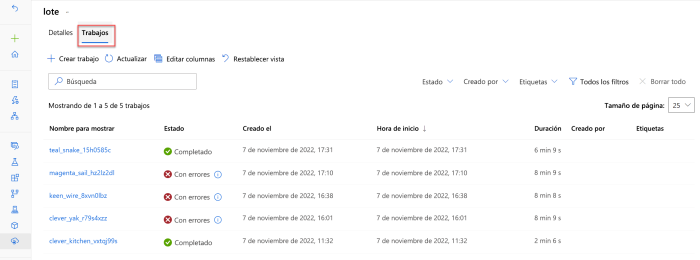


### Solución de problemas
El trabajo de puntuación por lotes se ejecuta como un job de pipeline. 
- se debe revisar detalles y resultados, y logs del propio job de pipeline.

Para solucionar problemas del script de puntuación, seleccionar el job secundario y revisar sus salidas y logs.
- `job_error.txt`: resume los errores del script.
- `job_progress_overview.txt`: proporciona información detallada sobre el número de minilotes procesados hasta el momento.
- `job_result.txt`: muestra errores al llamar a la función init() y run() en el script de puntuación.



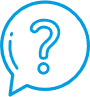
## **¿Preguntas?**


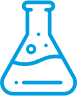
## **Lab 3**

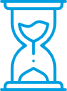
## **Ejercicio**

Usando el pipeline del dataset de precios de casas (data/house_price/data.csv):
- Entrena y despliega un modelo en un endpoint por lotes